#Classification of sample historical data using genotype array data
**Authors:** M. Swartz, R. Mogensen, S. Sandgaard og S. Zeeberg


#Import needed packages

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import math;

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from torch.nn.parameter import Parameter
from torch.nn.functional import relu, elu, softmax, log_softmax

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
# Setting a seed for repreducebility
torch.manual_seed(4444)

# Colors
dtu_green = "#1FD082B3";
dtu_blue = "#2F3EEAB3";
dtu_red = "#990000B3";

#Check for GPU

In [3]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

Running GPU.


#Import data

In [4]:
import pandas as pd

pcs = pd.read_csv('/content/drive/MyDrive/Deep Learning Project/Data/pcs.txt', sep = '\t')
pve = pd.read_csv('/content/drive/MyDrive/Deep Learning Project/Data/pve.txt', sep = '\t', header=None)
snp = pd.read_csv('/content/drive/MyDrive/Deep Learning Project/Data/snp_list', sep = '\t', header=None)
anno = pd.read_csv('/content/drive/MyDrive/Deep Learning Project/Data/v44.3_HO_public.anno', sep = '\t')

#Data wrangling

In [5]:
# Dict containing country as key and IID as ID for classification
unique_ages = anno['Full Date: One of two formats. (Format 1) 95.4% CI calibrated radiocarbon age (Conventional Radiocarbon Age BP, Lab number) e.g. 2624-2350 calBCE (3990±40 BP, Ua-35016). (Format 2) Archaeological context range, e.g. 2500-1700 BCE'].unique()
unique_ages_mean = anno['Date mean in BP [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]'].unique()
unique_countries = anno['Country'].unique()

# Check for the amount of unqiue classifiers
print('Ages: ', len(unique_ages))
print('Ages mean: ', len(unique_ages_mean))
print('Countries: ', len(unique_countries))

Ages:  3474
Ages mean:  2460
Countries:  144


##Country label

In [6]:
# Add country label
label_countries = []

for i in range(len(pcs)):
  c = anno['Country'][i] 
  if c[-1] == ' ':
    label_countries.append(c[:-1])
  elif c == '..' or c == 'HumanReferenceSequence': 
    label_countries.append('Missing')
  else:
    label_countries.append(c)
    
# adding country label
pcs2 = pcs.assign(countries = label_countries)
cols = list(pcs2)
cols = [cols[-1]] + cols[:-1]
pcs2 = pcs2[cols]

##Region label

In [7]:
# Get country regions
region = pd.read_html('https://meta.wikimedia.org/wiki/List_of_countries_by_regional_classification')
df_region = pd.concat(region)

region_names = df_region['Region'].unique()

# Make region dict
region_dict = {}
for i in range(len(region_names)):
  key = region_names[i]
  values = []
  for j in range(len(df_region)):
    if df_region['Region'][j] == region_names[i]:
      value = df_region['Country'][j]
      values.append(value)
  region_dict[region_names[i]] = values

# Add missing countries which are misspelled or changed in the wiki load
region_dict["Europe"].append("Russia")
region_dict["Europe"].append("Moldova")
region_dict["Europe"].append("Great Britain")
region_dict["Africa"].append("Tanzania")
region_dict["North America"].append("USA")
region_dict["Middle east"].append("Iran")
region_dict["Middle east"].append("Syria")
region_dict["Europe"].append("Abkhazia")
region_dict["Europe"].append("Czechoslovakia")
region_dict["Asia & Pacific"].append("South Korea")
region_dict["Asia & Pacific"].append("Brunei")
region_dict["Africa"].append("BotswanaOrNamibia")
region_dict["Europe"].append("Orkney Islands")
region_dict["Africa"].append("Western Sahara (Morocco)")
region_dict["Europe"].append("North Macedonia")
region_dict["Africa"].append("Canary Islands")
region_dict["Europe"].append("Crimea")
region_dict["South/Latin America"].append("Curacao")
region_dict["Asia & Pacific"].append("Laos")
region_dict["Africa"].append("DR Congo")
region_dict["South/Latin America"].append("St.Lucia")
region_dict["Europe"].append("Faroes")
region_dict["Missing"] = list(['Missing'])


label_region = []
#  Adding region label to dataframe
for i in range(len(pcs2['countries'])):
  keys = [key for key, value in region_dict.items() if pcs2['countries'][i] in value]
  if keys != []:
    key = keys[0]
  else:
    key = ''
  label_region.append(key)

# adding region label
pcs2 = pcs2.assign(region = label_region)
cols = list(pcs2)
cols = [cols[-1]] + cols[:-1]
pcs2 = pcs2[cols]

# Check missing countries in regions
# The following code is used to find the missing countries in our region_dict so they could be added manually
missing = []
for i in range(len(label_countries)):
  if label_region[i] == '' and label_countries[i] not in missing:
    missing.append(label_countries[i])
for c in missing:
  print(c)

##Era label

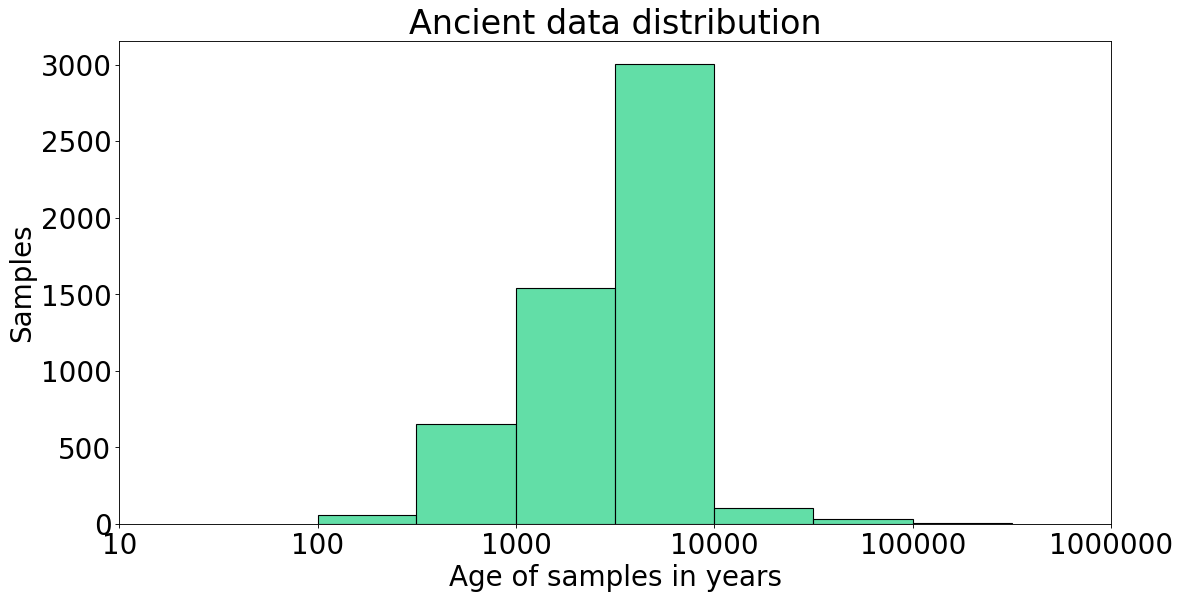

In [8]:
# Set eras
ages = anno['Date mean in BP [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]']

ages_class_list = []
ages_string_list = ['0','1 - 500', '501 - 1000', '1001 - 2000', '2001 - 4000', '4001 - 8000', '8001 - 16000', '16001 - 32000', '32001 - 64000', '64001 - 128000']
ages_string_list_num = list(range(len(ages_string_list)))
for i in range(len(ages)):
  if ages[i] == 0:
    ages_class_list.append(0)
  elif 0 < ages[i] <= 500:
    ages_class_list.append(1)
  elif 500 < ages[i] <= 1000:
    ages_class_list.append(2)
  elif 1000 < ages[i] <= 2000:
    ages_class_list.append(3)
  elif 2000 < ages[i] <= 4000:
    ages_class_list.append(4)
  elif 4000 < ages[i] <= 8000:
    ages_class_list.append(5)
  elif 8000 < ages[i] <= 16000:
    ages_class_list.append(6)
  elif 16000 < ages[i] <= 32000:
    ages_class_list.append(7)
  elif 32000 < ages[i] <= 64000:
    ages_class_list.append(8)
  else:
    ages_class_list.append(9)

pcs2['ages'] = ages_class_list

ages_ancient = [x for x in ages if x != 0]
#print(ages_ancient[0:10]);
ages_ancient = [math.log(x,10) for x in ages_ancient];
#print(ages_ancient[0:10]);


bin_table = [math.log(100,10),math.log(315,10),math.log(1000,10),math.log(3150,10),math.log(10000,10),math.log(31500,10),math.log(100000,10),math.log(315000,10)];
bin_table2 = bin_table[1:7];
plt.figure(figsize=(16,8),dpi=80)
plt.rcParams['font.size'] = '25'
plt.hist(ages_ancient, bins = bin_table,#,math.log(16000,10),math.log(32000,10),math.log(64000,10),math.log(128000,10)],
             color = dtu_green, edgecolor = 'black')
plt.xticks([1,2,3,4,5,6],["10","100","1000","10000","100000","1000000"])
plt.xlabel("Age of samples in years");
plt.ylabel("Samples");
plt.title('Ancient data distribution')
plt.rcParams.update({'font.size':18})
"""
ax = plt.subplot()
for i, v in enumerate(bin_table2):
    ax.text(i, math.exp(v) + 15, f"{round(v,1)}", color='black', ha="center", fontweight='bold')
"""

plt.show()

cols = list(pcs2)
cols = [cols[-1]] + cols[:-1]
pcs2 = pcs2[cols]

pcs2_ancient = pcs2[pcs2['ages'] != 0]
pcs2_modern = pcs2[pcs2['ages'] == 0]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


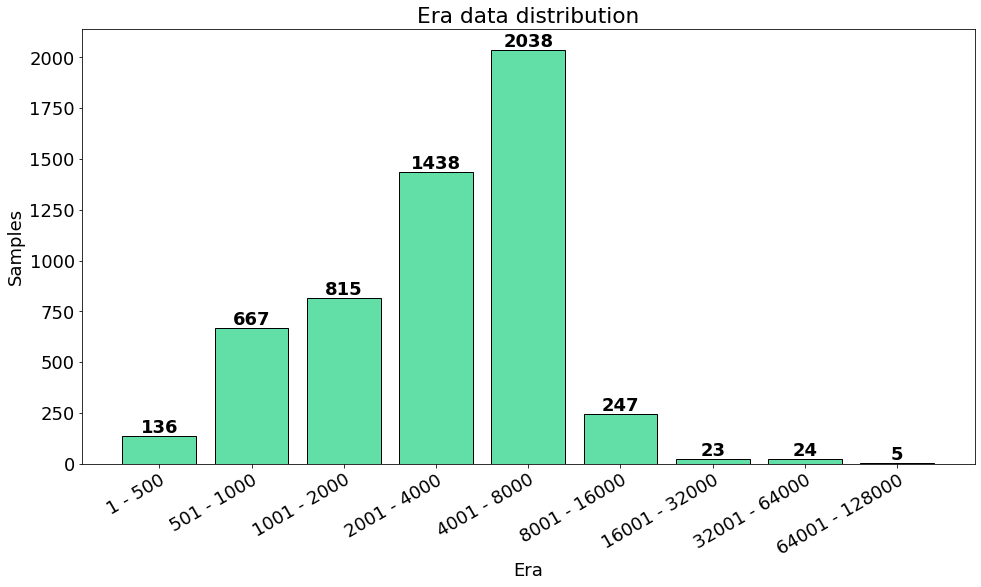

In [9]:
era_percentile = [len(pcs2_ancient[pcs2_ancient.ages == x]) for x in ages_string_list_num];
era_percentile = era_percentile[1:]
plt.figure(figsize=(16,8))
plt.bar(ages_string_list[1:],era_percentile,color=dtu_green,edgecolor="black");
plt.xticks(rotation=30,ha="right",rotation_mode="anchor")
plt.title("Era data distribution");
plt.xlabel("Era");
plt.ylabel("Samples");
ax = plt.subplot()
plt.rcParams.update({'font.size':18})
for i, v in enumerate(era_percentile):
    ax.text(i, v + 15, f"{v}", color='black', ha="center", fontweight='bold')
plt.show();

##Region histogram

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


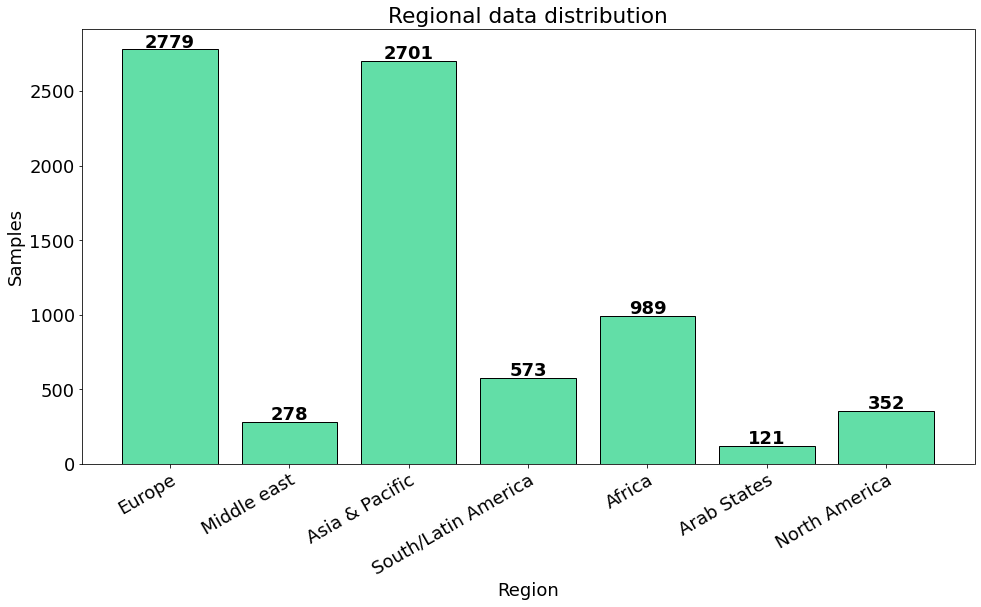

In [10]:
region_percentile = [len(pcs2_modern[pcs2_modern.region == x]) for x in region_names];

plt.figure(figsize=(16,8))
plt.bar(region_names,region_percentile,color=dtu_green,edgecolor="black");
plt.xticks(rotation=30,ha="right",rotation_mode="anchor")
plt.title("Regional data distribution");
plt.xlabel("Region");
plt.ylabel("Samples");
ax = plt.subplot()
plt.rcParams.update({'font.size':18})
for i, v in enumerate(region_percentile):
    ax.text(i, v + 15, f"{v}", color='black', ha="center", fontweight='bold')
plt.show();

##Ancient vs Present

In [11]:
# Check for the amount of unqiue classifiers
max_age = max(unique_ages_mean);
print('Max age:', max(unique_ages_mean))


# Add label
age = []

for i in range(len(pcs)):
  age.append(anno['Date mean in BP [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]'][i])

pcs3 = pcs2.assign(age = age);
max_age = max(pcs3['age']);                          # Update max age
print("Updated max age", max_age);

cols = list(pcs3)
cols = [cols[-1]] + cols[:-1]
pcs3 = pcs3[cols]
pcs3 = pcs3.iloc[:,0:14]; # Remove principal components


label_era = np.array([]);

mid_age = 3500;       # 5645 gives 1000 ancient data
max_age = 20000;

for i in range(len(pcs3)):
  c = pcs3["age"][i];
  if c == 0:  # Present day
    label_era = np.append(label_era,0);
  elif c < mid_age: # New'ish
    label_era = np.append(label_era,2);
  elif c < max_age:   # Ancient
    label_era = np.append(label_era,1);
  else:
    label_era = np.append(label_era,3);

print("Present data:\t",len(label_era[label_era == 0]))
print("Too new data:\t",len(label_era[label_era == 2]))
print("Ancient data:\t",len(label_era[label_era == 1]))
print("Too old data:\t",len(label_era[label_era == 3]))

pcs3 = pcs3.assign(era = label_era)
cols = list(pcs3)
cols = [cols[-1]] + cols[:-1]
pcs3 = pcs3[cols]

Max age: 110450
Updated max age 110450
Present data:	 7804
Too new data:	 2471
Ancient data:	 2873
Too old data:	 49


In [12]:
## Standardize size of ancient and present day

# Remove too new and too old data
pcs4 = pcs3[pcs3.era != 2];
pcs4 = pcs4[pcs4.era != 3];

# Most 'old' data is from Europe, thus this classification is only run on Europe data
# Remove other data than Europe:
pcs4 = pcs4[pcs4.region == "Europe"];

print("Present Data:");
for elem in region_names:
  print(len(pcs4[pcs4.region == elem][pcs4.era == 0]),elem,sep="\t");
print("\nAncient Data:");
for elem in region_names:
  print(len(pcs4[pcs4.region == elem][pcs4.era == 1]),elem,sep="\t");


# Standardize size of classes
size_anc = len(pcs4[pcs4.era == 1]);
size_pre = len(pcs4[pcs4.era == 0]);
if size_anc < size_pre:
  pcs5 = pcs4[pcs4.era == 0][0:size_anc];  # Present data
  pcs5 = pcs4.append(pcs4[pcs4.era == 1]);  # Ancient data
else:
  pcs5 = pcs4[pcs4.era == 1][0:size_pre];   # Ancient data
  pcs5 = pcs5.append(pcs4[pcs4.era == 0]);  # Present data

print("\nSize of each class:\t", np.minimum(size_anc,size_pre));

# Drop region, countries and age data as they do not provide new info that we need
pcs5 = pcs5.drop(columns=['age','countries','region', 'IID']);

Present Data:
2779	Europe
0	Middle east
0	Asia & Pacific
0	South/Latin America
0	Africa
0	Arab States
0	North America

Ancient Data:
2358	Europe
0	Middle east
0	Asia & Pacific
0	South/Latin America
0	Africa
0	Arab States
0	North America

Size of each class:	 2358


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykern

##PCA

In [13]:
pcs6 = pcs2.drop(columns='ages')

##Regression

In [14]:
# Add label
label = []

for i in range(len(pcs)):
  label.append(anno['Date mean in BP [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]'][i])

pcs7 = pcs.assign(label = label);
#pcs7 = pcs7[pcs7['label'] != 0];      # Remove modern data
pcs7 = pcs7[pcs7['label'] < 10000];   # Remove data that is too ancient for the model to perform well.
max_age = max(pcs7['label']);                          # Update max age
print("Updated max age", max_age);

cols = list(pcs7)
cols = [cols[-1]] + cols[:-1]
pcs7 = pcs7[cols]
#pcs7 = pcs7.iloc[:,0:13];

Updated max age 9993


#Classification of region (modern)

In [15]:
# Determine if we are using ancient or modern data
#pcs2 = pcs2_ancient
pcs2 = pcs2_modern

# Drop variables not used
pcs2 = pcs2.drop(columns=['ages','countries'])
pcs2 = pcs2.iloc[:,:11]

label_used = 'region'

# Random sorting
x_temp = pcs2.sample(frac=1)

print('Uniques Classes:', len(x_temp[label_used].unique()))

# Set minimums criteria for the number of labels
min = 30

# Dict and list to follow the labels to drop
drop_dict = {}
drop_list = []

# Find all the labels to drop
for elem in x_temp[label_used].unique():
  #print(len(x_train_temp['label'][x_train_temp['label']==elem]),"\t",elem)
  if len(x_temp[label_used][x_temp[label_used]==elem]) < min:
    drop_dict[str(elem)] = len(x_temp[label_used][x_temp[label_used]==elem])
    drop_list.append(elem)


# Drop the labels in test and validation
x_temp = x_temp[~x_temp.region.isin(drop_list)]

# Split data into training, test and validation
x_traint = x_temp[int(len(x_temp)*(0.4)):]
x_train_target = x_traint.region
x_testt = x_temp[int(len(x_temp)*(0.2)):int(len(x_temp)*(0.4))]
x_test_target = x_testt.region
x_valt = x_temp[:int(len(x_temp)*(0.2))]
x_val_target = x_valt.region

# Convert data to tensors
le = preprocessing.LabelEncoder();
x_train_labels = x_traint.columns.values[3:];
x_train = torch.tensor(x_traint[x_train_labels].values).float();
targets_train = torch.as_tensor(le.fit_transform(x_train_target));

x_test_labels = x_testt.columns.values[3:];
x_test = torch.tensor(x_testt[x_test_labels].values).float();
targets_test = torch.as_tensor(le.fit_transform(x_test_target));

x_val_labels = x_valt.columns.values[3:];
x_valid = torch.tensor(x_valt[x_val_labels].values).float();
targets_valid = torch.as_tensor(le.fit_transform(x_val_target));

# Show the number of unique countries in each set
print(f'\nAfter data cleaning using a minimum criteria of: {min}\n')
print('Training uniques:', '\tClasses = ', len(x_traint[label_used].unique()), '\t\tUnqiue individuals:', len(x_traint))
print('Test uniques: ', '\t\tClasses = ', len(x_testt[label_used].unique()), '\t\tUnqiue individuals:', len(x_testt))
print('Validation uniques: ', '\tClasses = ', len(x_valt[label_used].unique()), '\t\tUnqiue individuals:', len(x_valt))

print('\nClasses dropped: ', drop_list)

ms_labels = []

aa = targets_train.unique();
bb = targets_test.unique()
cc = targets_valid.unique()
p_classes = le.inverse_transform(cc)
for l in range(len(aa)):
  if aa[l] not in bb or aa[1] not in cc:
    ms_labels.append(aa[l])
print('Missing classes between datasets: ', ms_labels)

print('Encoding')
print(torch.unique(targets_train))

Uniques Classes: 8

After data cleaning using a minimum criteria of: 30

Training uniques: 	Classes =  7 		Unqiue individuals: 4676
Test uniques:  		Classes =  7 		Unqiue individuals: 1559
Validation uniques:  	Classes =  7 		Unqiue individuals: 1558

Classes dropped:  ['Missing']
Missing classes between datasets:  []
Encoding
tensor([0, 1, 2, 3, 4, 5, 6])


##Build network

In [16]:
# Set
classes = len(x_traint[label_used].unique())

# Hyperparameters
num_classes = classes;
num_l1 = 100;
num_l2 = 100;
num_l3 = 100;
num_l4 = 1024;
num_l5 = 512;
num_l6 = 256;
num_l7 = 128;
num_features = x_train.shape[1]
L2 = 0.00001                                                                                     # <-- Set weight decay
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1, num_hidden2, num_output):
        super(Net, self).__init__() 
        
        # Input layer 
        self.first_layer = nn.Linear(in_features = num_features,
                                  out_features = num_l1,
                                  bias = True);
        self.hid_layer1 = nn.Linear(in_features = num_l1,
                                out_features = num_l2,
                                bias = True);
        self.hid_layer2 = nn.Linear(in_features = num_l2,
                                out_features = num_classes,
                                bias = False);

        # Additional layers

        self.dropout = nn.Dropout(0.10);
        self.batchnorm_input = nn.BatchNorm1d(num_features);
        self.batchnorm_l1 = nn.BatchNorm1d(num_l1);
        self.batchnorm_l2 = nn.BatchNorm1d(num_l2);

        # Additional batchnorms
        
        # define activation function in constructor
        self.activation1 = torch.nn.ReLU(); 
        self.activation2 = torch.nn.ELU();

    def forward(self, x):

        x = self.first_layer(x);

        x = self.batchnorm_l1(x);        
        x = self.activation1(x);
        x = self.dropout(x);

        x = self.hid_layer1(x);
        
        x = self.batchnorm_l2(x);
        x = self.activation1(x);
        x = self.dropout(x);
        
        x = self.hid_layer2(x);

        return log_softmax(x,dim=1)

net = Net(num_features, num_l1, num_l2, num_classes)
print(net);

Net(
  (first_layer): Linear(in_features=8, out_features=100, bias=True)
  (hid_layer1): Linear(in_features=100, out_features=100, bias=True)
  (hid_layer2): Linear(in_features=100, out_features=7, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm_input): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_l1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_l2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ReLU()
  (activation2): ELU(alpha=1.0)
)


##Optimizer

In [17]:
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.5,weight_decay=0.01)

nsamples = len(pcs2);
nclasses = len(p_classes);
nsamplej = [len(pcs2[pcs2.region == x]) for x in p_classes];
w_loss = torch.tensor([nsamples/(nclasses * nsamplej[i]) for i in range(nclasses)]);

criterion = nn.NLLLoss(weight=w_loss);

##Training loop

Epoch  1 : Train Loss 10.332105 , Train acc 0.046237, Valid acc 0.040523
Epoch 11 : Train Loss 7.140735 , Train acc 0.675914, Valid acc 0.693464
Epoch 21 : Train Loss 6.237234 , Train acc 0.697849, Valid acc 0.706536
Epoch 31 : Train Loss 5.637941 , Train acc 0.723871, Valid acc 0.719608
Epoch 41 : Train Loss 5.231890 , Train acc 0.736774, Valid acc 0.729412
Epoch 51 : Train Loss 4.930368 , Train acc 0.747742, Valid acc 0.735294
Epoch 61 : Train Loss 4.636980 , Train acc 0.754839, Valid acc 0.749673
Epoch 71 : Train Loss 4.398598 , Train acc 0.774194, Valid acc 0.762745
Epoch 81 : Train Loss 4.260654 , Train acc 0.777419, Valid acc 0.764706
Epoch 91 : Train Loss 4.129858 , Train acc 0.784086, Valid acc 0.777778
Epoch 101 : Train Loss 4.006709 , Train acc 0.784516, Valid acc 0.779085
Epoch 111 : Train Loss 3.899587 , Train acc 0.787312, Valid acc 0.785621
Epoch 121 : Train Loss 3.776437 , Train acc 0.789462, Valid acc 0.781046
Epoch 131 : Train Loss 3.694260 , Train acc 0.788817, Valid 

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

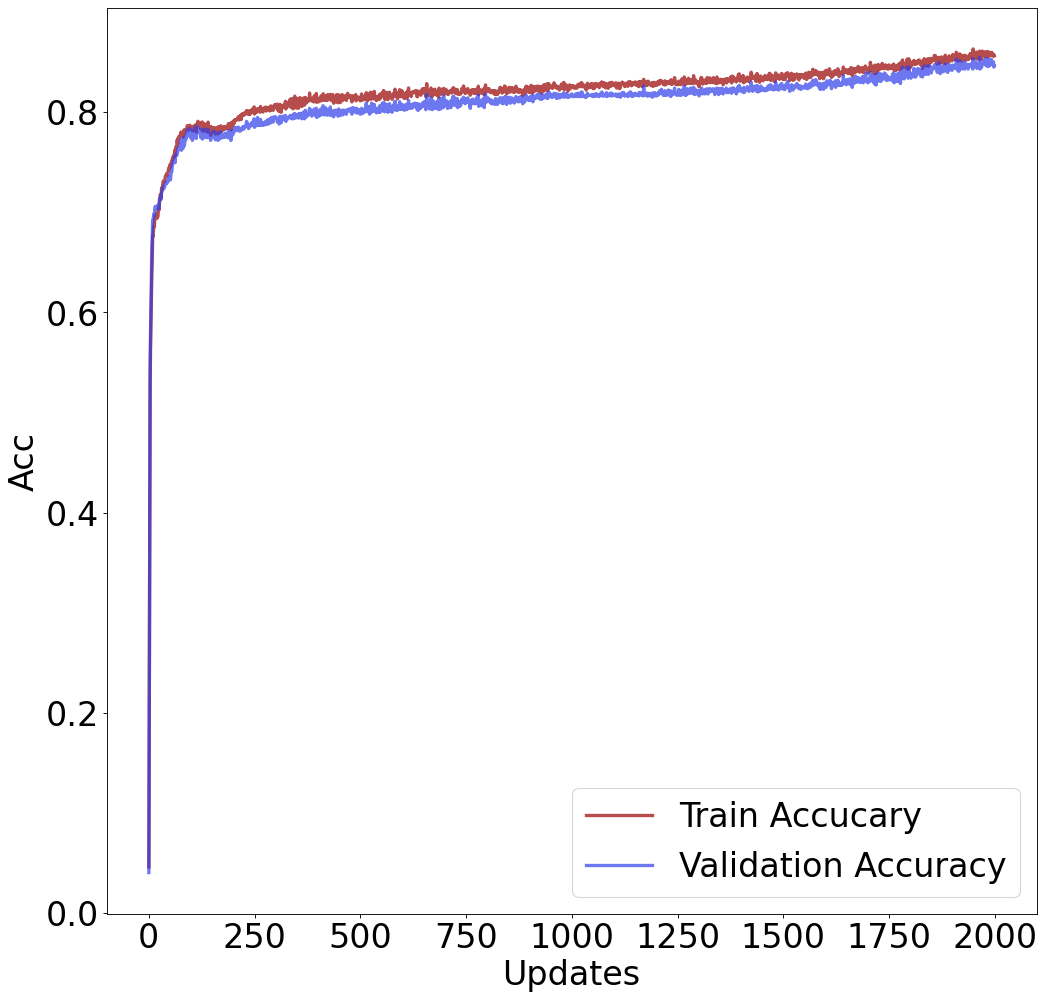

In [18]:
# setting hyperparameters and gettings epoch sizes
batch_size = 30
num_epochs = 2000
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []
m = nn.Dropout(p=0.2)                                                           # <-- Define Dropout

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])                                      # <-- Insert dropout and batchnorm

        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure(figsize=(15,15),dpi=80)
plt.rcParams['font.size'] = '30'
plt.plot(epoch, train_acc, dtu_red, epoch, valid_acc, dtu_blue,linewidth=3.0)
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

##Prediction accuracy

99.1%	accuracy	|	correct:220	|	false: 2 	in :: Africa
76.9%	accuracy	|	correct:20	|	false: 6 	in :: Arab States
87.9%	accuracy	|	correct:464	|	false: 64 	in :: Asia & Pacific
75.8%	accuracy	|	correct:398	|	false: 127 	in :: Europe
97.9%	accuracy	|	correct:47	|	false: 1 	in :: Middle east
77.3%	accuracy	|	correct:51	|	false: 15 	in :: North America
82.6%	accuracy	|	correct:95	|	false: 20 	in :: South/Latin America


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


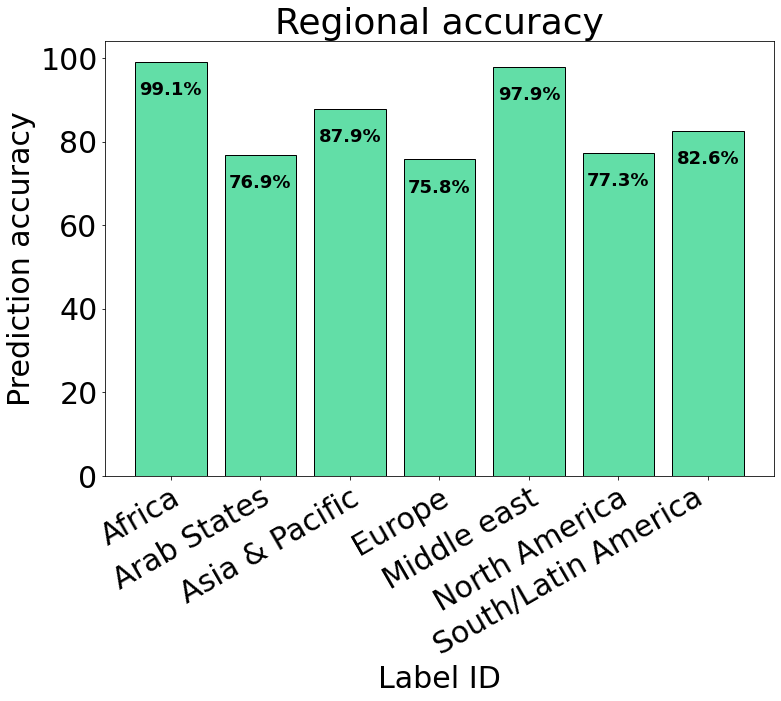

In [19]:

true_guess_list = [0]*len(cc)
false_gues_list = [0]*len(cc)
total_guess_list= [0]*len(cc)
ac_list = [0]*len(cc)

p_classes = le.inverse_transform(cc)
for j in range(len(val_targs)):
  if val_targs[j] == val_preds[j]:
    true_guess_list[val_targs[j]] += 1
    total_guess_list[val_targs[j]] += 1
  else:
    false_gues_list[val_targs[j]] += 1
    total_guess_list[val_targs[j]] += 1


for i in range(len(p_classes)):

  if true_guess_list[i] == 0:
    ac = 0
    ac_list[i] = ac
  if false_gues_list[i] == 0:
    ac = 100
    ac_list[i] = ac
  else:
    ac = round((true_guess_list[i]/total_guess_list[i])*100,1) 
    ac_list[i] = ac
  print(f"{ac}%\taccuracy\t|\tcorrect:{true_guess_list[i]}\t|\tfalse: {false_gues_list[i]} \tin :: {p_classes[i]}")
  

# Plot predictions

x = p_classes
y = ac_list
plt.figure(figsize=(12,8))
plt.xlabel('Label ID')
plt.ylabel('Prediction accuracy')
plt.title('Regional accuracy')
plt.xticks(rotation=30,rotation_mode="anchor",ha="right")
plt.rcParams.update({'font.size':18})
plt.bar(x,y,color=(dtu_green),edgecolor='black')
ax = plt.subplot()
for i, v in enumerate(y):
    ax.text(i , v - 8, f"{v}%", color='Black', ha = 'center', fontweight='bold')
plt.show()
plt.rcParams.update({'font.size':26})


##Confusion matrix

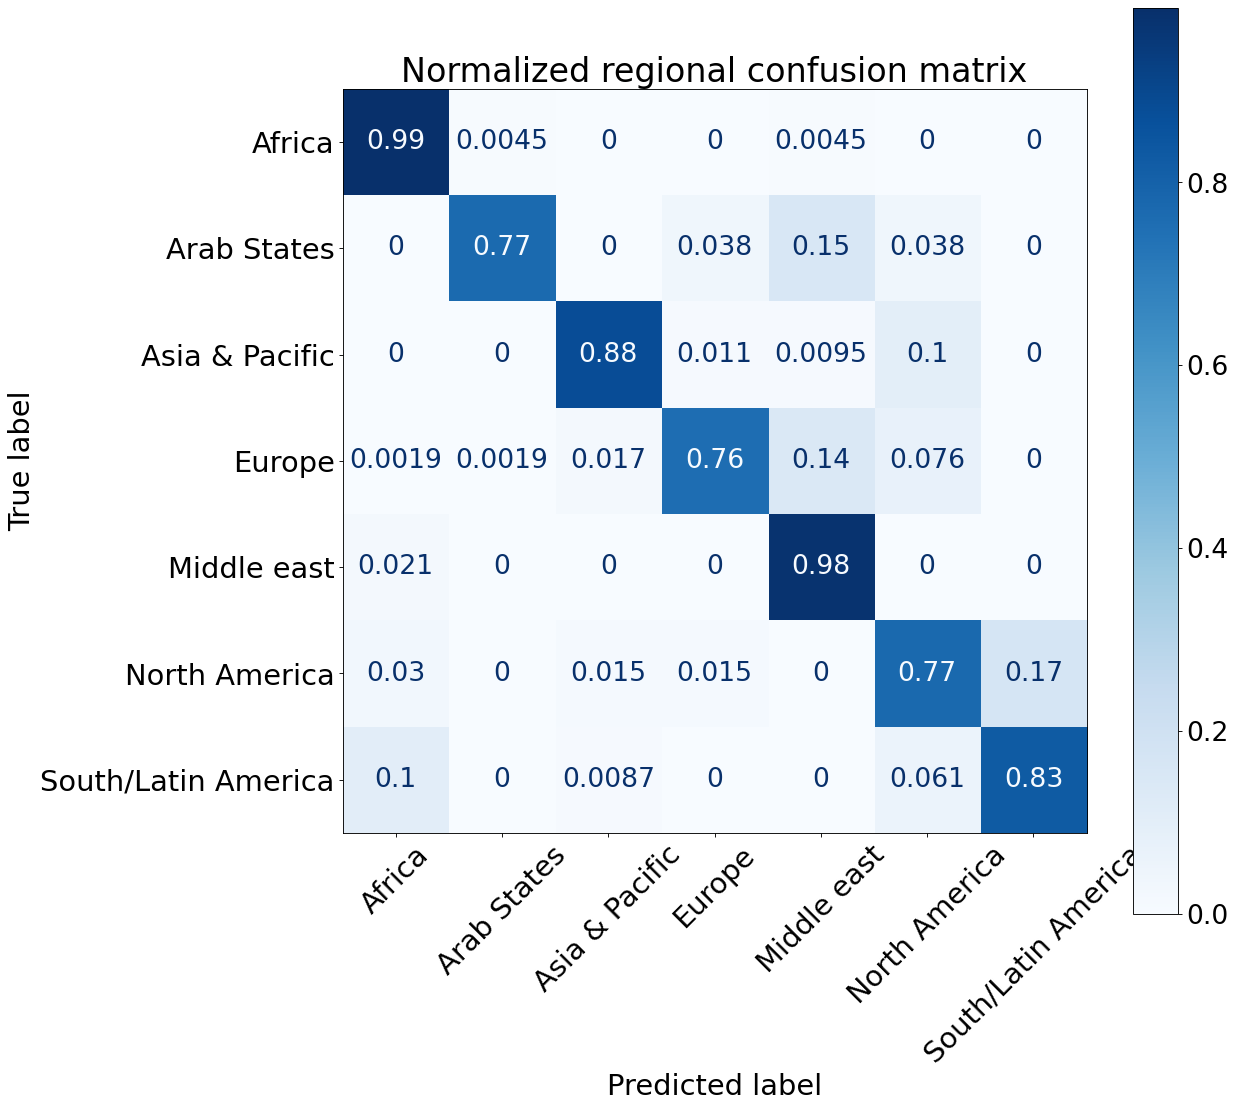

In [20]:
a = le.inverse_transform(val_targs)
b = le.inverse_transform(val_preds)

fig, ax = plt.subplots(figsize=(15,15),dpi=80)
plt.rcParams['font.size'] = '24'
ax.set_title('Normalized regional confusion matrix', fontsize=30)
disp = ConfusionMatrixDisplay.from_predictions(a,b,normalize='true',cmap=plt.cm.Blues,labels=p_classes,xticks_rotation=45,ax=ax)
plt.show()

In [21]:
plt.rcParams['font.size'] = '12'

#Classification of ages (ancient)

In [22]:
# Determine if we are using ancient or modern data
pcs2 = pcs2_ancient
pcs2 = pcs2.iloc[:,:13]

# Drop variables not used
pcs2 = pcs2.drop(columns=['region','countries'])

label_used = 'ages'

# Random sorting
x_temp = pcs2.sample(frac=1)
print('Uniques Classes:', len(x_temp[label_used].unique()))

# Set minimums criteria for the number of labels
min = 30

# Dict and list to follow the labels to drop
drop_dict = {}
drop_list = []

# Find all the labels to drop
for elem in x_temp[label_used].unique():
  if len(x_temp[label_used][x_temp[label_used]==elem]) < min:
    drop_dict[str(elem)] = len(x_temp[label_used][x_temp[label_used]==elem])
    drop_list.append(elem)

# Drop the labels in test and validation
x_temp = x_temp[~x_temp.ages.isin(drop_list)]

# Split data into training, test and validation
x_traint = x_temp[int(len(x_temp)*(0.4)):]
x_train_target = x_traint.ages
x_testt = x_temp[int(len(x_temp)*(0.2)):int(len(x_temp)*(0.4))]
x_test_target = x_testt.ages
x_valt = x_temp[:int(len(x_temp)*(0.2))]
x_val_target = x_valt.ages

# Convert data to tensors
le = preprocessing.LabelEncoder();
x_train_labels = x_traint.columns.values[3:];
x_train = torch.tensor(x_traint[x_train_labels].values).float();
targets_train = torch.as_tensor(le.fit_transform(x_train_target));

x_test_labels = x_testt.columns.values[3:];
x_test = torch.tensor(x_testt[x_test_labels].values).float();
targets_test = torch.as_tensor(le.fit_transform(x_test_target));

x_val_labels = x_valt.columns.values[3:];
x_valid = torch.tensor(x_valt[x_val_labels].values).float();
targets_valid = torch.as_tensor(le.fit_transform(x_val_target));

# Show the number of unique countries in each set
print(f'\nAfter data cleaning using a minimum criteria of: {min}\n')
print('Training uniques:', '\tClasses = ', len(x_traint[label_used].unique()), '\t\tUnqiue individuals:', len(x_traint))
print('Test uniques: ', '\t\tClasses = ', len(x_testt[label_used].unique()), '\t\tUnqiue individuals:', len(x_testt))
print('Validation uniques: ', '\tClasses = ', len(x_valt[label_used].unique()), '\t\tUnqiue individuals:', len(x_valt))

print('\nClasses dropped: ', drop_list)

ms_labels = []

aa = targets_train.unique();
bb = targets_test.unique()
cc = targets_valid.unique()
p_classes = le.inverse_transform(cc)
for l in range(len(aa)):
  if aa[l] not in bb or aa[1] not in cc:
    ms_labels.append(aa[l])
print('Missing classes between datasets: ', ms_labels)

print('Encoding')
print(torch.unique(targets_train))

Uniques Classes: 9

After data cleaning using a minimum criteria of: 30

Training uniques: 	Classes =  6 		Unqiue individuals: 3205
Test uniques:  		Classes =  6 		Unqiue individuals: 1068
Validation uniques:  	Classes =  6 		Unqiue individuals: 1068

Classes dropped:  [8, 9, 7]
Missing classes between datasets:  []
Encoding
tensor([0, 1, 2, 3, 4, 5])


##Build network

In [23]:
# Set
classes = len(x_traint[label_used].unique())

# Hyperparameters
num_classes = classes;
num_l1 = 100;
num_l2 = 200;
num_l3 = 100;
num_l4 = 1024;
num_l5 = 512;
num_l6 = 256;
num_l7 = 128;
num_features = x_train.shape[1]
L2 = 0.00001                                                                                     # <-- Set weight decay
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1, num_hidden2, num_output):
        super(Net, self).__init__() 
        
        # Input layer 
        self.first_layer = nn.Linear(in_features = num_features,
                                  out_features = num_l1,
                                  bias = True);
        self.hid_layer1 = nn.Linear(in_features = num_l1,
                                out_features = num_l2,
                                bias = True);
        self.hid_layer2 = nn.Linear(in_features = num_l2,
                                out_features = num_classes,
                                bias = False);
        self.hid_layer3 = nn.Linear(in_features = num_l3,
                                out_features = num_l4,
                                bias = True);
        self.hid_layer4 = nn.Linear(in_features = num_l4,
                                out_features = num_l5,
                                bias = True);
        self.hid_layer5 = nn.Linear(in_features = num_l5,
                                out_features = num_l6,
                                bias = True);
        self.hid_layer6 = nn.Linear(in_features = num_l6,
                                out_features = num_l7,
                                bias = True);
        self.out_layer = nn.Linear(in_features = num_l7,
                                out_features = num_classes,
                                bias = False);

        self.conv1 = nn.Conv1d(in_channels=num_features,
                               out_channels=num_l1,
                               kernel_size = 5,
                               stride = 1,
                               padding = 1);

        self.gru = nn.GRU(100, 100, 1);
        
        self.dropout = nn.Dropout(0.10);
        self.batchnorm_input = nn.BatchNorm1d(num_features);
        self.batchnorm_l1 = nn.BatchNorm1d(num_l1);
        self.batchnorm_l2 = nn.BatchNorm1d(num_l2);
        self.batchnorm_l3 = nn.BatchNorm1d(num_l3);
        self.batchnorm_l4 = nn.BatchNorm1d(num_l4);
        self.batchnorm_l5 = nn.BatchNorm1d(num_l5);
        self.batchnorm_l6 = nn.BatchNorm1d(num_l6);
        self.batchnorm_l7 = nn.BatchNorm1d(num_l7);

        # define activation function in constructor
        self.activation1 = torch.nn.ReLU();                                      
        self.activation2 = torch.nn.ELU();

    def forward(self, x):

        x = self.batchnorm_input(x);
        x = self.first_layer(x);

        x = self.batchnorm_l1(x);        
        x = self.activation1(x);
        x = self.dropout(x);

        x = self.hid_layer1(x);
        
        x = self.batchnorm_l2(x);
        x = self.activation1(x);
        x = self.dropout(x);
        
        x = self.hid_layer2(x);

        return log_softmax(x,dim=1)

net = Net(num_features, num_l1, num_l2, num_classes)
print(net);

Net(
  (first_layer): Linear(in_features=8, out_features=100, bias=True)
  (hid_layer1): Linear(in_features=100, out_features=200, bias=True)
  (hid_layer2): Linear(in_features=200, out_features=6, bias=False)
  (hid_layer3): Linear(in_features=100, out_features=1024, bias=True)
  (hid_layer4): Linear(in_features=1024, out_features=512, bias=True)
  (hid_layer5): Linear(in_features=512, out_features=256, bias=True)
  (hid_layer6): Linear(in_features=256, out_features=128, bias=True)
  (out_layer): Linear(in_features=128, out_features=6, bias=False)
  (conv1): Conv1d(8, 100, kernel_size=(5,), stride=(1,), padding=(1,))
  (gru): GRU(100, 100)
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm_input): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_l1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_l2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchno

##Optimizer

In [24]:
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.5,weight_decay=0.01)

nsamples = len(pcs2);
nclasses = len(p_classes);
nsamplej = [len(pcs2[pcs2.ages == x]) for x in p_classes];
w_loss = torch.tensor([nsamples/(nclasses * nsamplej[i]) for i in range(nclasses)]);

criterion = nn.CrossEntropyLoss(weight=w_loss);

##Training loop

Epoch  1 : Train Loss 6.732038 , Train acc 0.219182, Valid acc 0.208571
Epoch 11 : Train Loss 5.968308 , Train acc 0.277358, Valid acc 0.261905
Epoch 21 : Train Loss 5.784726 , Train acc 0.363522, Valid acc 0.356190
Epoch 31 : Train Loss 5.641171 , Train acc 0.429245, Valid acc 0.408571
Epoch 41 : Train Loss 5.567400 , Train acc 0.446855, Valid acc 0.431429
Epoch 51 : Train Loss 5.529941 , Train acc 0.449371, Valid acc 0.428571
Epoch 61 : Train Loss 5.477311 , Train acc 0.452830, Valid acc 0.438095
Epoch 71 : Train Loss 5.410920 , Train acc 0.461321, Valid acc 0.446667
Epoch 81 : Train Loss 5.361140 , Train acc 0.460377, Valid acc 0.443810
Epoch 91 : Train Loss 5.331702 , Train acc 0.466981, Valid acc 0.447619
Epoch 101 : Train Loss 5.322814 , Train acc 0.472013, Valid acc 0.449524
Epoch 111 : Train Loss 5.265505 , Train acc 0.472956, Valid acc 0.449524
Epoch 121 : Train Loss 5.262442 , Train acc 0.475472, Valid acc 0.452381
Epoch 131 : Train Loss 5.216527 , Train acc 0.477044, Valid a

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

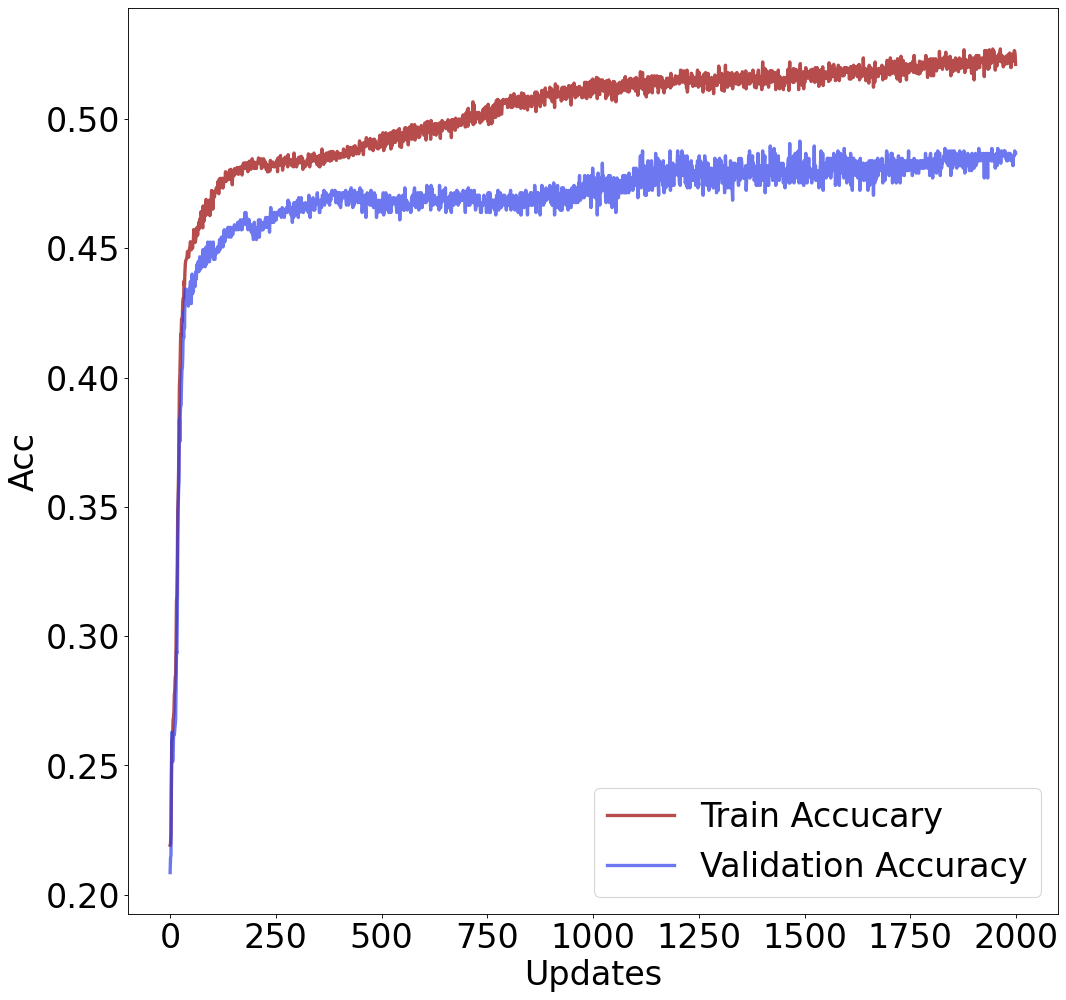

In [25]:
# setting hyperparameters and gettings epoch sizes
batch_size = 30
num_epochs = 2000
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []
m = nn.Dropout(p=0.4)                                                           # <-- Define Dropout

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])                                      # <-- Insert dropout and batchnorm

        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure(figsize=(15,15),dpi=80)
plt.rcParams['font.size'] = '30'
plt.plot(epoch, train_acc, dtu_red, epoch, valid_acc, dtu_blue, linewidth=3.0)
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

##Prediction accuracy

41%	accuracy	|	correct:13	|	false: 19 	in :: 1
74%	accuracy	|	correct:98	|	false: 34 	in :: 2
17%	accuracy	|	correct:29	|	false: 137 	in :: 3
66%	accuracy	|	correct:182	|	false: 95 	in :: 4
42%	accuracy	|	correct:169	|	false: 233 	in :: 5
49%	accuracy	|	correct:20	|	false: 21 	in :: 6


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


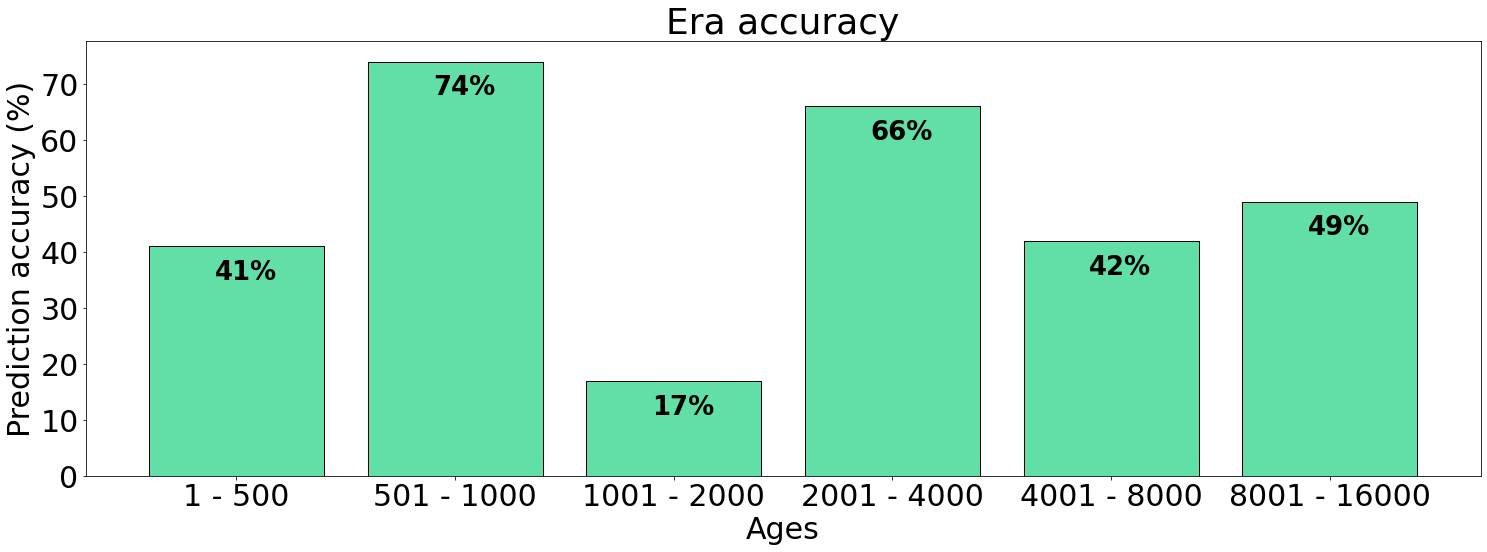

In [26]:
true_guess_list = [0]*9
false_gues_list = [0]*9
total_guess_list= [0]*9
ac_list = [0]*9

p_classes = le.inverse_transform(cc)
for j in range(len(val_targs)):
  if val_targs[j] == val_preds[j]:
    true_guess_list[val_targs[j]] += 1
    total_guess_list[val_targs[j]] += 1
  else:
    false_gues_list[val_targs[j]] += 1
    total_guess_list[val_targs[j]] += 1

for i in range(len(p_classes)):
  if true_guess_list[i] == 0:
    ac = 0
    ac_list[i] = ac
  if false_gues_list[i] == 0:
    ac = 100
  else:
    ac = round((true_guess_list[i]/total_guess_list[i])*100) 
    ac_list[i] = ac
  print(f"{ac}%\taccuracy\t|\tcorrect:{true_guess_list[i]}\t|\tfalse: {false_gues_list[i]} \tin :: {p_classes[i]}")
  

# Plot predictions

#x = cc.tolist()
x = ages_string_list[1:7]
y = ac_list[:6]
plt.figure(figsize=(25,8))
plt.xlabel('Ages')
plt.ylabel('Prediction accuracy (%)')
plt.title('Era accuracy')
ax = plt.subplot()
xx = len(x)
plt.bar(x,y,color=(dtu_green),edgecolor='black')
plt.rcParams['font.size'] = '26'
for i, v in enumerate(y):
      ax.text(i -.1 , v - 6, f"{v}%", color='black', fontweight='bold')

plt.show()

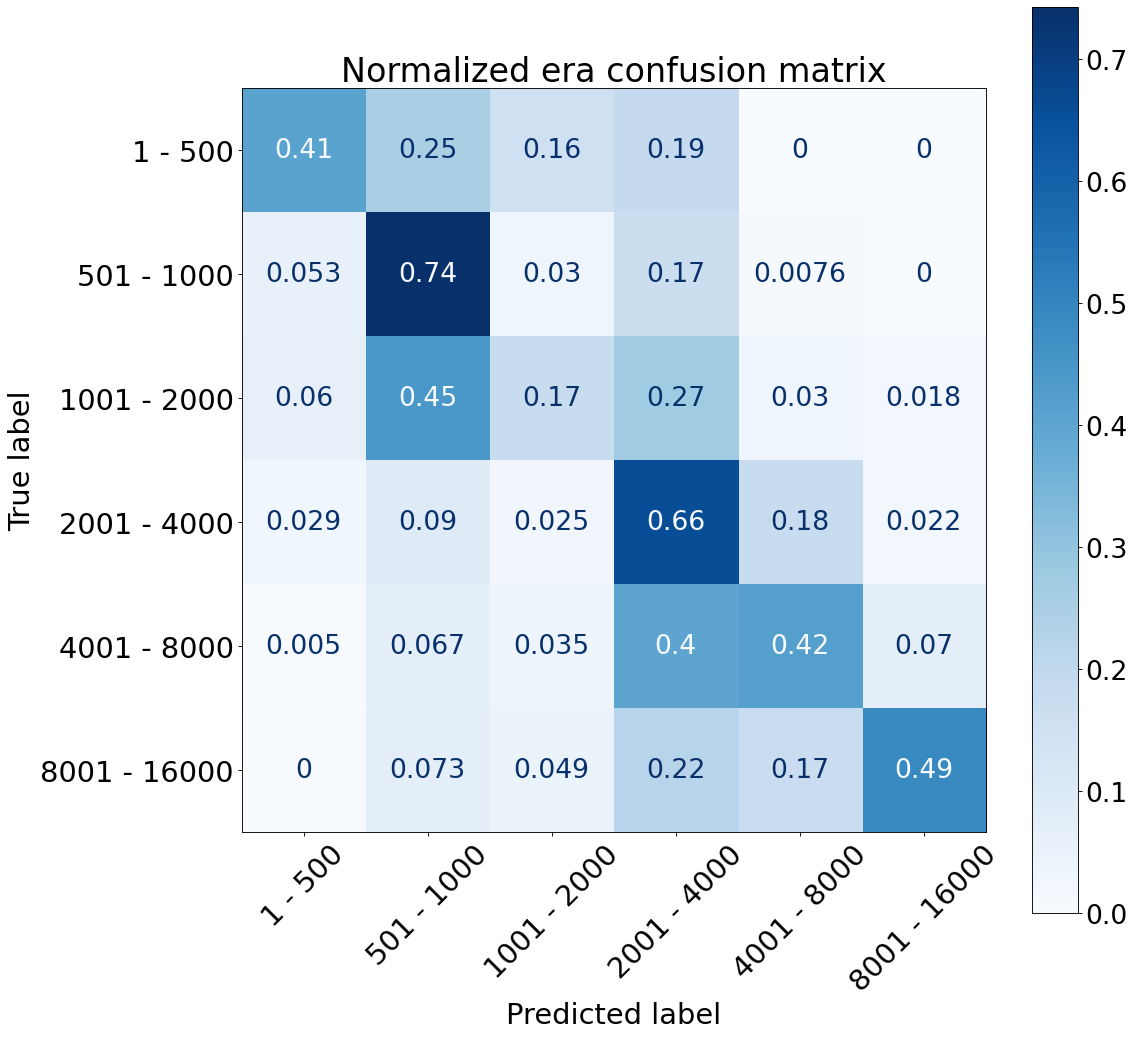

In [27]:
a = []*len(val_targs)
b = []*len(val_preds)
ages_string_list = ages_string_list[1:7]

for i in range(len(val_targs)):
  for j in range(len(ages_string_list)):
    if val_targs[i] == j:
      a.append(ages_string_list[j])
    if val_preds[i] == j:
      b.append(ages_string_list[j])
a = np.array(a)
b = np.array(b)
l = np.array(ages_string_list)

fig, ax = plt.subplots(figsize=(15,15),dpi=80)

plt.rcParams['font.size'] = '24'
ax.set_title('Normalized era confusion matrix', fontsize=30)
disp = ConfusionMatrixDisplay.from_predictions(a,b,normalize='true',cmap=plt.cm.Blues,labels=l,xticks_rotation=45,ax=ax)
plt.show()

#Present vs Ancient

In [28]:
# Random sorting
x_temp = pcs5.sample(frac=1)

# Remove 'mid age data'
#x_temp = x_temp[x_temp['era'] != 2];


# Split data into training, test and validation
x_traint = x_temp[int(len(x_temp)*(0.4)):]
x_train_target = x_traint.era
x_testt = x_temp[int(len(x_temp)*(0.2)):int(len(x_temp)*(0.4))]
x_test_target = x_testt.era
x_valt = x_temp[:int(len(x_temp)*(0.2))]
x_val_target = x_valt.era

# Convert data to tensors
le = preprocessing.LabelEncoder();
x_train_labels = np.array(x_traint.columns.values[3:])
x_train = torch.tensor(x_traint[x_train_labels].values).float();
targets_train = torch.as_tensor(np.array(x_train_target),dtype=torch.long);

x_test_labels = x_testt.columns.values[3:];
x_test = torch.tensor(x_testt[x_test_labels].values).float();
targets_test = torch.as_tensor(np.array(x_test_target),dtype=torch.long);

x_val_labels = x_valt.columns.values[3:];
x_valid = torch.tensor(x_valt[x_val_labels].values).float();
targets_valid = torch.as_tensor(np.array(x_val_target),dtype=torch.long);

# Show the number of unique countries in each set
print(f'\nAfter data cleaning using a minimum criteria of: {min}\n')
print('Training uniques:', '\tClasses = ', len(x_traint["era"].unique()), '\t\tUnqiue individuals:', len(x_traint))
print('Test uniques: ', '\t\tClasses = ', len(x_testt["era"].unique()), '\t\tUnqiue individuals:', len(x_testt))
print('Validation uniques: ', '\tClasses = ', len(x_valt["era"].unique()), '\t\tUnqiue individuals:', len(x_valt))

ms_labels = []

aa = targets_train.unique();
bb = targets_test.unique()
cc = targets_valid.unique()

for l in range(len(aa)): 
  if aa[l] not in bb or aa[1] not in cc:
    ms_labels.append(aa[l])
print('Missing classes between datasets: ', ms_labels)

print('Encoding')


After data cleaning using a minimum criteria of: 30

Training uniques: 	Classes =  2 		Unqiue individuals: 4497
Test uniques:  		Classes =  2 		Unqiue individuals: 1499
Validation uniques:  	Classes =  2 		Unqiue individuals: 1499
Missing classes between datasets:  []
Encoding


## Build network

In [29]:
# Set
classes = len(x_traint["era"].unique())

# Hyperparameters
num_classes = classes;
num_l1 = 50# 100;
num_l2 = 50# 100;
num_l3 = 50# 100;
num_features = x_train.shape[1]
L2 = 0.00001                                                                                     # <-- Set weight decay
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1, num_hidden2, num_output):
        super(Net, self).__init__() 
        
        # Input layer 
        self.first_layer = nn.Linear(in_features = num_features,
                                  out_features = num_l1,
                                  bias = True);
        self.hid_layer1 = nn.Linear(in_features = num_l1,
                                out_features = num_l2,
                                bias = True);
        self.hid_layer2 = nn.Linear(in_features = num_l2,
                                out_features = num_l3,
                                bias = True);
        self.out_layer = nn.Linear(in_features = num_l3,
                                out_features = num_classes,
                                bias = False);

        self.conv1 = nn.Conv1d(in_channels=num_features,
                               out_channels=num_l1,
                               kernel_size = 5,
                               stride = 1,
                               padding = 1);

        self.gru = nn.GRU(100, 100, 1);
        
        self.dropout = nn.Dropout(0.30);
        self.batchnorm_l1 = nn.BatchNorm1d(num_l1,momentum=0.9);
        self.batchnorm_hid = nn.BatchNorm1d(num_l2);

        # define activation function in constructor
        self.activation1 = torch.nn.ReLU();                                                        # <-- Change to ReLU
        self.activation2 = torch.nn.ELU();

    def forward(self, x):

        x = self.first_layer(x);

        x = self.batchnorm_l1(x);        
        x = self.activation1(x);
        x = self.dropout(x);

        x = self.hid_layer1(x);
        
        x = self.batchnorm_hid(x);
        x = self.activation1(x);
        x = self.dropout(x);
        
        x = self.hid_layer2(x);
        
        x = self.batchnorm_hid(x);
        x = self.activation1(x);
        x = self.dropout(x);

        x = self.out_layer(x);

        return log_softmax(x,dim=1)#softmax(x)

net = Net(num_features, num_l1, num_l2, num_classes)
print(net);

print("Classes:",num_classes);
print("Target. shape:",(targets_train-1).unique());

Net(
  (first_layer): Linear(in_features=8, out_features=50, bias=True)
  (hid_layer1): Linear(in_features=50, out_features=50, bias=True)
  (hid_layer2): Linear(in_features=50, out_features=50, bias=True)
  (out_layer): Linear(in_features=50, out_features=2, bias=False)
  (conv1): Conv1d(8, 50, kernel_size=(5,), stride=(1,), padding=(1,))
  (gru): GRU(100, 100)
  (dropout): Dropout(p=0.3, inplace=False)
  (batchnorm_l1): BatchNorm1d(50, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (batchnorm_hid): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ReLU()
  (activation2): ELU(alpha=1.0)
)
Classes: 2
Target. shape: tensor([-1,  0])


##Optimizer

In [30]:
#optimizer = optim.Adam(net.parameters(), lr=0.00001, weight_decay=0.01, eps=1e-08,betas=(0.9,0.999),amsgrad=False) 
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.5,weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

##Training loop

Epoch  1 : Train Loss 0.338529 , Train acc 0.289318, Valid acc 0.270714
Epoch 51 : Train Loss 0.237333 , Train acc 0.856818, Valid acc 0.869286
Epoch 101 : Train Loss 0.196175 , Train acc 0.884773, Valid acc 0.897857
Epoch 151 : Train Loss 0.165703 , Train acc 0.899773, Valid acc 0.907143
Epoch 201 : Train Loss 0.143891 , Train acc 0.912273, Valid acc 0.913571
Epoch 251 : Train Loss 0.125775 , Train acc 0.921364, Valid acc 0.929286
Epoch 301 : Train Loss 0.110954 , Train acc 0.934318, Valid acc 0.937143
Epoch 351 : Train Loss 0.105765 , Train acc 0.941818, Valid acc 0.948571
Epoch 401 : Train Loss 0.094406 , Train acc 0.947045, Valid acc 0.949286
Epoch 451 : Train Loss 0.087326 , Train acc 0.952727, Valid acc 0.955000
Epoch 501 : Train Loss 0.082741 , Train acc 0.953636, Valid acc 0.955714
Epoch 551 : Train Loss 0.076118 , Train acc 0.957273, Valid acc 0.957857
Epoch 601 : Train Loss 0.073938 , Train acc 0.960682, Valid acc 0.960714
Epoch 651 : Train Loss 0.068490 , Train acc 0.962500,

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

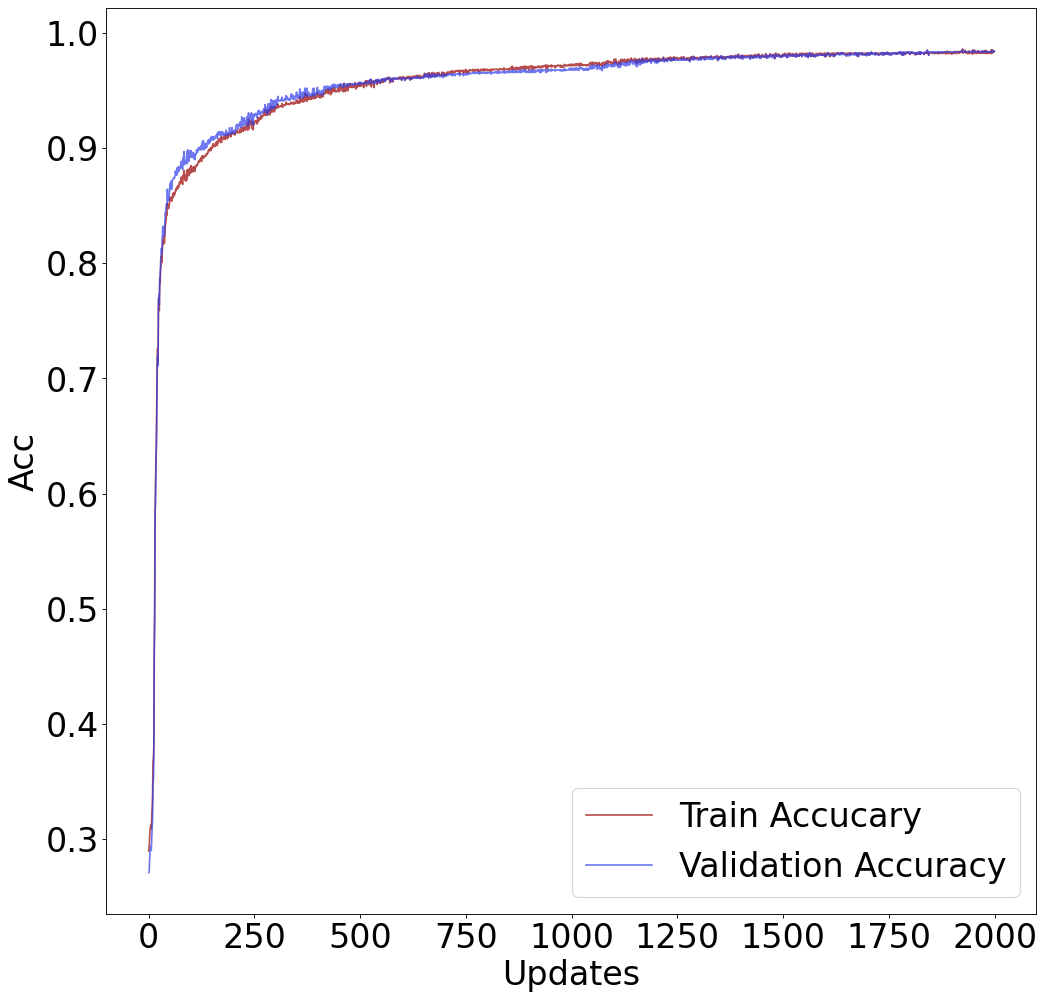

In [31]:
# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 2000
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []
m = nn.Dropout(p=0.2)                                                           # <-- Define Dropout
#mm = nn.BatchNorm1d(len(x_train[0]),momentum=0.9)                               # <-- Define Batchnorm and set to length of x_train[0] (this is 784 in this case)

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])                                      # <-- Insert dropout and batchnorm

        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
        

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 50 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.rcParams['font.size'] = '30'
plt.figure(figsize=(15, 15), dpi=80)
plt.plot(epoch, train_acc, dtu_red, epoch, valid_acc, dtu_blue)
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

##Prediction accuracy

100%	accuracy	|	correct:506	|	false: 1 	in :: 0
98%	accuracy	|	correct:872	|	false: 21 	in :: 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


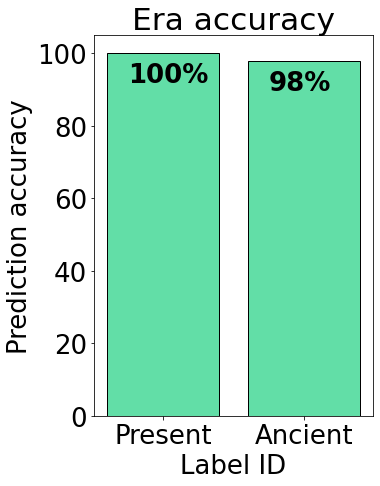

In [32]:
le = preprocessing.LabelEncoder()# <- added

true_guess_list = [0]*len(cc)
false_gues_list = [0]*len(cc)
total_guess_list= [0]*len(cc)
ac_list = [0]*len(cc)

cc = le.fit_transform(cc) # <- added
p_classes = le.inverse_transform(cc)
for j in range(len(val_targs)):
  if val_targs[j] == val_preds[j]:
    true_guess_list[val_targs[j]] += 1
    total_guess_list[val_targs[j]] += 1
  else:
    false_gues_list[val_targs[j]] += 1
    total_guess_list[val_targs[j]] += 1


for i in range(len(p_classes)):

  if true_guess_list[i] == 0:
    ac = 0
    ac_list[i] = ac
  if false_gues_list[i] == 0:
    ac = 100
    ac_list[i] = ac
  else:
    ac = round((true_guess_list[i]/total_guess_list[i])*100) 
    ac_list[i] = ac
  print(f"{ac}%\taccuracy\t|\tcorrect:{true_guess_list[i]}\t|\tfalse: {false_gues_list[i]} \tin :: {p_classes[i]}")
  

# Plot predictions

#x = cc.tolist()
x = p_classes
x = ["Present", "Ancient"]
#y = true_guess_list
y = ac_list
plt.figure(figsize=(5,7))
plt.rcParams['font.size'] = '26'
plt.xlabel('Label ID')
plt.ylabel('Prediction accuracy')
plt.title('Era accuracy')
ax = plt.subplot()
for i, v in enumerate(y):
    ax.text(i -.25 , v - 8, f"{v}%", color='black', fontweight='bold')
plt.bar(x,y, color = dtu_green, edgecolor = 'black')
plt.show()



#PCA comparison

In [33]:
# Add the missing region
p_classes = np.array(['Europe', 'Africa', 'North America', 'Middle east', 'Asia & Pacific', 'South/Latin America', 'Arab States', 'Missing'])

palette = ['lightcoral','darkorange','palegreen','darkcyan','deepskyblue','magenta','yellow', 'grey']
#farve = ['blue','red','green','yellow','orange','purple','black']
colors = {}
for i in range(len(p_classes)):
    colors[p_classes[i]] = palette[i]

print(colors)

{'Europe': 'lightcoral', 'Africa': 'darkorange', 'North America': 'palegreen', 'Middle east': 'darkcyan', 'Asia & Pacific': 'deepskyblue', 'South/Latin America': 'magenta', 'Arab States': 'yellow', 'Missing': 'grey'}


In [34]:
import matplotlib.patches as mpatches
p1 = mpatches.Patch(color='lightcoral', label='Europe')
p2 = mpatches.Patch(color='darkorange', label='Africa')
p3 = mpatches.Patch(color='palegreen', label='North America')
p4 = mpatches.Patch(color='darkcyan', label='Middle east')
p5 = mpatches.Patch(color='deepskyblue', label='Asia & Pacific')
p6 = mpatches.Patch(color='magenta', label='South/Latin America')
p7 = mpatches.Patch(color='yellow', label='Arab States')
p8 = mpatches.Patch(color='grey', label='Missing')

In [35]:
plt.rcParams['font.size'] = '12'

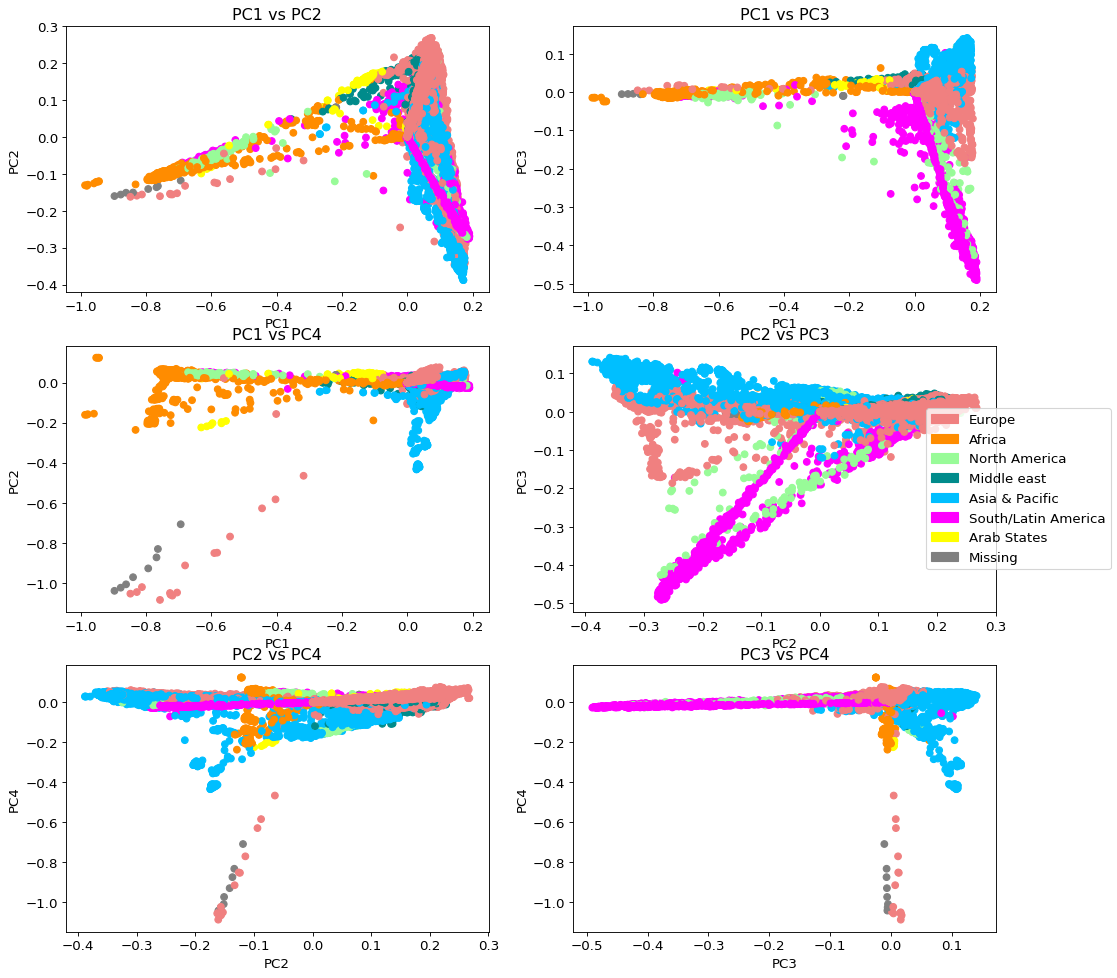

In [36]:
fig, axs = plt.subplots(3,2,figsize=(15,15),dpi=80)
l1=axs[0, 0].scatter(pcs6.iloc[:,4], pcs6.iloc[:,5], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[0, 0].set_title('PC1 vs PC2')
axs[0, 0].set(xlabel='PC1', ylabel='PC2')

l2=axs[0, 1].scatter(pcs6.iloc[:,4], pcs6.iloc[:,6], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[0, 1].set_title('PC1 vs PC3')
axs[0, 1].set(xlabel='PC1', ylabel='PC3')


l3=axs[1, 0].scatter(pcs6.iloc[:,4], pcs6.iloc[:,7], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[1, 0].set_title('PC1 vs PC4')
axs[1, 0].set(xlabel='PC1', ylabel='PC2')


l4=axs[1, 1].scatter(pcs6.iloc[:,5], pcs6.iloc[:,6], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[1, 1].set_title('PC2 vs PC3')
axs[1, 1].set(xlabel='PC2', ylabel='PC3')


l5=axs[2, 0].scatter(pcs6.iloc[:,5], pcs6.iloc[:,7], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[2, 0].set_title('PC2 vs PC4')
axs[2, 0].set(xlabel='PC2', ylabel='PC4')


l6=axs[2, 1].scatter(pcs6.iloc[:,6], pcs6.iloc[:,7], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[2, 1].set_title('PC3 vs PC4')
axs[2, 1].set(xlabel='PC3', ylabel='PC4')


fig.legend(handles=[p1, p2, p3, p4, p5, p6, p7, p8], loc='center right')


#PCA - 3 Plot

In [37]:
# Add the missing region
#p_classes = np.array(['Europe', 'Africa', 'Asia & Pacific'])
p_classes = np.array(['Europe', 'Africa', 'North America', 'Middle east', 'Asia & Pacific', 'South/Latin America', 'Arab States', 'Missing'])

# Colors
palette = [dtu_green,dtu_blue,dtu_red,'yellow','orange','purple','black','grey']
colors = {}
for i in range(len(p_classes)):
    colors[p_classes[i]] = palette[i]
print(colors)

#drop_list = ['North America','Middle east','South/Latin America','Arab States','Missing']
#pcs2 = pcs2[~pcs2.region.isin(drop_list)]



{'Europe': '#1FD082B3', 'Africa': '#2F3EEAB3', 'North America': '#990000B3', 'Middle east': 'yellow', 'Asia & Pacific': 'orange', 'South/Latin America': 'purple', 'Arab States': 'black', 'Missing': 'grey'}


In [38]:
import matplotlib.patches as mpatches
p1 = mpatches.Patch(color=dtu_red, label='Europe')
p2 = mpatches.Patch(color=dtu_green, label='Africa')
p3 = mpatches.Patch(color=dtu_red, label='North America')
p4 = mpatches.Patch(color='yellow', label='Middle east')
p3 = mpatches.Patch(color='orange', label='Asia & Pacific')
p6 = mpatches.Patch(color='purple', label='South/Latin America')
p7 = mpatches.Patch(color='black', label='Arab States')
p8 = mpatches.Patch(color='grey', label='Missing')

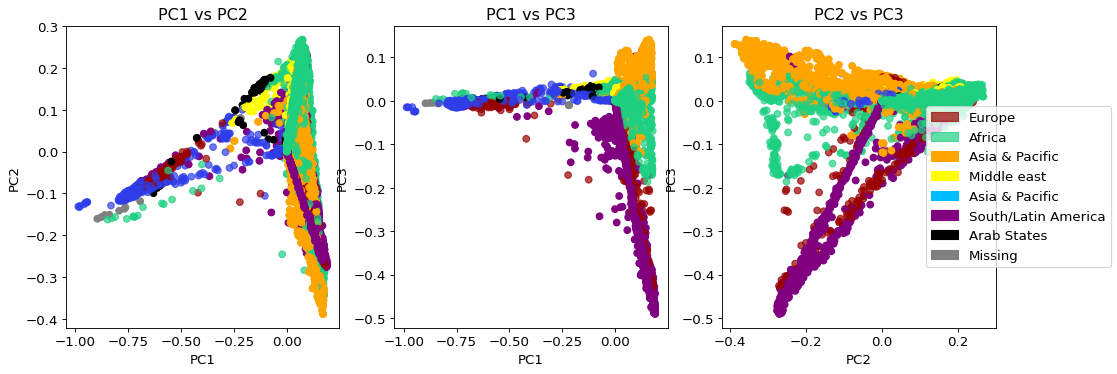

In [39]:
fig, axs = plt.subplots(1,3,figsize=(15,5),dpi=80)
l1=axs[0].scatter(pcs6.iloc[:,4], pcs6.iloc[:,5], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[0].set_title('PC1 vs PC2')
axs[0].set(xlabel='PC1', ylabel='PC2')

l2=axs[1].scatter(pcs6.iloc[:,4], pcs6.iloc[:,6], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[1].set_title('PC1 vs PC3')
axs[1].set(xlabel='PC1', ylabel='PC3')

"""
l3=axs[1, 0].scatter(pcs6.iloc[:,4], pcs6.iloc[:,7], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[1, 0].set_title('PC1 vs PC4')
axs[1, 0].set(xlabel='PC1', ylabel='PC2')
"""
l4=axs[2].scatter(pcs6.iloc[:,5], pcs6.iloc[:,6], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[2].set_title('PC2 vs PC3')
axs[2].set(xlabel='PC2', ylabel='PC3')

"""
l5=axs[1, 1].scatter(pcs6.iloc[:,5], pcs6.iloc[:,7], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[1, 1].set_title('PC2 vs PC4')
axs[1, 1].set(xlabel='PC2', ylabel='PC4')

l6=axs[2, 1].scatter(pcs6.iloc[:,6], pcs6.iloc[:,7], color=[colors[i] for i in pcs6.iloc[:,0]])
axs[2, 1].set_title('PC3 vs PC4')
axs[2, 1].set(xlabel='PC3', ylabel='PC4')
"""

fig.legend(handles=[p1, p2, p3,p4,p5,p6,p7,p8], loc='center right')


#Regression

In [40]:
# Random sorting
x_temp = pcs7.sample(frac=1)

# Split data into training, test and validation
x_traint = x_temp[int(len(x_temp)*(0.4)):]
x_train_target = x_traint.label/max_age;   #anno['Date mean in BP [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]']/110450
x_testt = x_temp[int(len(x_temp)*(0.2)):int(len(x_temp)*(0.4))]
x_test_target = x_testt.label/max_age;     #anno['Date mean in BP [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]']/110450
x_valt = x_temp[:int(len(x_temp)*(0.2))]
x_val_target = x_valt.label/max_age;       #anno['Date mean in BP [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]']/110450

# Convert data to tensors
x_train_labels = x_traint.columns.values[3:];
x_train = torch.tensor(x_traint[x_train_labels].values).float();
targets_train = torch.as_tensor(x_train_target.values).float();

x_test_labels = x_testt.columns.values[3:];
x_test = torch.tensor(x_testt[x_test_labels].values).float();
targets_test = torch.as_tensor(x_test_target.values).float();

x_valid_labels = x_valt.columns.values[3:];
x_valid = torch.tensor(x_valt[x_valid_labels].values).float();
targets_valid = torch.as_tensor(x_val_target.values).float();

##Build network

In [41]:
# Hyperparameters
num_classes = 1;
num_l1 = 100;
num_l2 = 50;
num_l3 = 25;
num_features = x_train.shape[1]
L2 = 0.00001                                                                                     # <-- Set weight decay
softmax = lambda x: np.exp(x) / np.sum(np.exp(x))

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden1, num_hidden2, num_output):
        super(Net, self).__init__() 
        
        # Input layer 
        self.first_layer = nn.Linear(in_features = num_features,
                                  out_features = num_l1,
                                  bias = True);
        self.hid_layer1 = nn.Linear(in_features = num_l1,
                                out_features = num_l2,
                                bias = True);
        self.hid_layer2 = nn.Linear(in_features = num_l2,
                                out_features = num_l3,
                                bias = True);
        self.out_layer = nn.Linear(in_features = num_l3,
                                out_features = 1,
                                bias = True);

        self.conv1 = nn.Conv1d(in_channels=50,
                               out_channels=num_l1,
                               kernel_size = 5,
                               stride = 1,
                               padding = 2);
        self.mp1 = nn.MaxPool1d(8);

        self.gru = nn.GRU(100, 100, 1);
        
        self.dropout = nn.Dropout(0.2);
        self.batchnorm_l1 = nn.BatchNorm1d(num_l1);
        self.batchnorm_hid1 = nn.BatchNorm1d(num_l2,momentum=0.95);
        self.batchnorm_hid2 = nn.BatchNorm1d(num_l3,momentum=0.95);

        # define activation function in constructor
        self.activation1 = torch.nn.ReLU();                                                        # <-- Change to ReLU
        self.activation2 = torch.nn.ELU();
        self.activation3 = torch.nn.LogSigmoid();
        self.activation4 = torch.nn.Softplus();

    def forward(self, x):
        
        x = self.first_layer(x);
        
        #x = self.batchnorm_l1(x);        
        x = self.activation1(x);
        x = self.dropout(x);
        
        x = self.hid_layer1(x);

        x = self.activation1(x);

        #x = self.batchnorm_hid1(x);
        x = self.activation1(x);
        x = self.dropout(x);
        
        x = self.hid_layer2(x);
        
        #x = self.batchnorm_hid2(x);
        x = self.activation1(x);
        x = self.dropout(x);

        x = self.out_layer(x);

        return x;

net = Net(num_features, num_l1, num_l2, num_classes)
print(net);

Net(
  (first_layer): Linear(in_features=4000, out_features=100, bias=True)
  (hid_layer1): Linear(in_features=100, out_features=50, bias=True)
  (hid_layer2): Linear(in_features=50, out_features=25, bias=True)
  (out_layer): Linear(in_features=25, out_features=1, bias=True)
  (conv1): Conv1d(50, 100, kernel_size=(5,), stride=(1,), padding=(2,))
  (mp1): MaxPool1d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (gru): GRU(100, 100)
  (dropout): Dropout(p=0.2, inplace=False)
  (batchnorm_l1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm_hid1): BatchNorm1d(50, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
  (batchnorm_hid2): BatchNorm1d(25, eps=1e-05, momentum=0.95, affine=True, track_running_stats=True)
  (activation1): ReLU()
  (activation2): ELU(alpha=1.0)
  (activation3): LogSigmoid()
  (activation4): Softplus(beta=1, threshold=20)
)


##Optimizer

In [42]:
# optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01, eps=1e-08,betas=(0.9,0.999),amsgrad=False) 
optimizer = optim.SGD(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

##Training Loop - Simplified

In [43]:
num_epochs = 1000;
num_samples_train = x_train.shape[0];
num_samples_valid = x_valid.shape[0];

train_loss = [];
valid_loss = [];

for epoch in range(num_epochs):
  # Forward
  pred = net(x_train);
  loss = criterion(pred,targets_train);

  # Backwards
  loss.backward();

  # Update
  optimizer.step();

  optimizer.zero_grad();

  if (epoch+1)%50 == 0:
    print("Epoch",epoch+1,"Loss:",loss.item());



/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([7836])) that is different to the input size (torch.Size([7836, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 50 Loss: 0.07893770933151245
Epoch 100 Loss: 0.07241052389144897
Epoch 150 Loss: 0.06748096644878387
Epoch 200 Loss: 0.06368257105350494
Epoch 250 Loss: 0.06061932072043419
Epoch 300 Loss: 0.0583244152367115
Epoch 350 Loss: 0.056618209928274155
Epoch 400 Loss: 0.055136051028966904
Epoch 450 Loss: 0.05413167551159859
Epoch 500 Loss: 0.05333397537469864
Epoch 550 Loss: 0.05263747274875641
Epoch 600 Loss: 0.05219196900725365
Epoch 650 Loss: 0.051815588027238846
Epoch 700 Loss: 0.051554907113313675
Epoch 750 Loss: 0.05133874714374542
Epoch 800 Loss: 0.051159556955099106
Epoch 850 Loss: 0.05102961137890816
Epoch 900 Loss: 0.05092654377222061
Epoch 950 Loss: 0.05084685608744621
Epoch 1000 Loss: 0.05078895390033722


0.14859058 0.12871955
<generator object Module.parameters at 0x7f53b0234650>


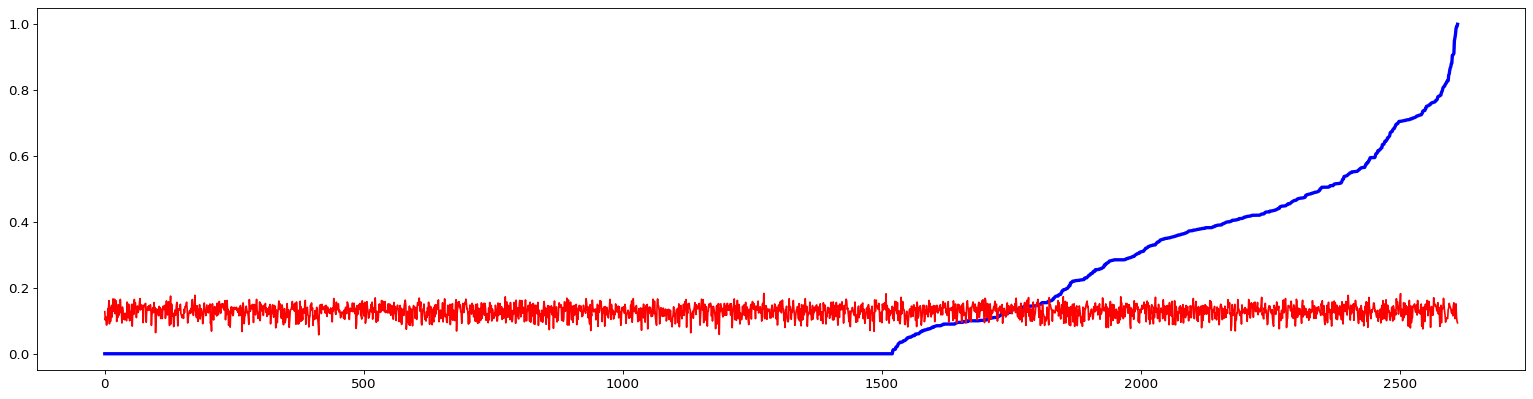

In [44]:
y1 = np.array(targets_valid);
y1_sort = np.sort(y1);

y2 = net(x_valid).detach().numpy().flatten();
i = np.argsort(y1)
y2_sort = y2[i]

y3 = np.array([y1_sort,y2_sort]);

y4 = np.array([y1,y2]);
i = np.argsort(y4,axis=1)[0];
y4 = y4[:,i];

print(np.mean(y4[0]),np.mean(y4[1]));
print(net.parameters());

plt.figure(figsize=(24, 6), dpi=80)
plt.plot(range(len(x_valid)),y4[0],'b',linewidth=3.0);
plt.plot(range(len(x_valid)),y4[1],'r');
plt.show();

In [45]:
pcs7.iloc[:,3]

0       -0.728952
1       -0.720496
2       -0.737449
3       -0.733609
4       -0.726743
           ...   
13192    0.008863
13193    0.064764
13194    0.077624
13195    0.051431
13196    0.004950
Name: PC1, Length: 13060, dtype: float64

"\naxs[1, 1].scatter(pcs7.iloc[:,4], pcs7.iloc[:,6], c = age, cmap = 'Greens_r')\naxs[1, 1].set_title('PC2 vs PC4')\naxs[1, 1].set(xlabel='PC2', ylabel='PC4')\n\naxs[2, 1].scatter(pcs7.iloc[:,5], pcs7.iloc[:,6], c = age, cmap = 'Greens_r')\naxs[2, 1].set_title('PC3 vs PC4')\naxs[2, 1].set(xlabel='PC3', ylabel='PC4')\n"

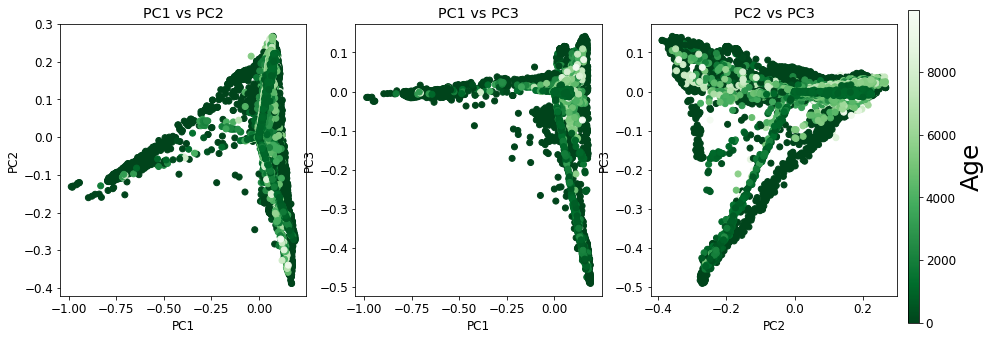

In [46]:
age = pcs7.iloc[:,0]


fig, axs = plt.subplots(1,3,figsize=(15,5))
#fig.tight_layout(pad=3.0)
#plt.rcParams['font.size'] = '20'

m=axs[0].scatter(pcs7.iloc[:,3], pcs7.iloc[:,4], c = age, cmap = 'Greens_r')
axs[0].set_title('PC1 vs PC2')
axs[0].set(xlabel='PC1', ylabel='PC2')

cb_ax = fig.add_axes([0.91, 0.05, 0.01, 0.87])
cbar = plt.colorbar(m, cax=cb_ax)
cbar.set_label(label = 'Age', size=25) 

axs[1].scatter(pcs7.iloc[:,3], pcs7.iloc[:,5], c = age, cmap = 'Greens_r')
axs[1].set_title('PC1 vs PC3')
axs[1].set(xlabel='PC1', ylabel='PC3')

"""
axs[1, 0].scatter(pcs7.iloc[:,3], pcs7.iloc[:,6], c = age, cmap = 'Greens')
axs[1, 0].set_title('PC1 vs PC4')
axs[1, 0].set(xlabel='PC1', ylabel='PC2')

"""
axs[2].scatter(pcs7.iloc[:,4], pcs7.iloc[:,5], c = age, cmap = 'Greens_r')
axs[2].set_title('PC2 vs PC3')
axs[2].set(xlabel='PC2', ylabel='PC3')


"""
axs[1, 1].scatter(pcs7.iloc[:,4], pcs7.iloc[:,6], c = age, cmap = 'Greens_r')
axs[1, 1].set_title('PC2 vs PC4')
axs[1, 1].set(xlabel='PC2', ylabel='PC4')

axs[2, 1].scatter(pcs7.iloc[:,5], pcs7.iloc[:,6], c = age, cmap = 'Greens_r')
axs[2, 1].set_title('PC3 vs PC4')
axs[2, 1].set(xlabel='PC3', ylabel='PC4')
"""


##Training loop

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch  1 : Train Loss: 0.000508,	Train Loss Corrected: 1989.096267,	Validation Loss: N/A
Epoch  6 : Train Loss: 0.000507,	Train Loss Corrected: 1986.342404,	Validation Loss: N/A
Epoch 11 : Train Loss: 0.000506,	Train Loss Corrected: 1985.853349,	Validation Loss: N/A
Epoch 16 : Train Loss: 0.000506,	Train Loss Corrected: 1985.435749,	Validation Loss: N/A
Epoch 21 : Train Loss: 0.000506,	Train Loss Corrected: 1985.552195,	Validation Loss: N/A
Epoch 26 : Train Loss: 0.000506,	Train Loss Corrected: 1985.230664,	Validation Loss: N/A
Epoch 31 : Train Loss: 0.000506,	Train Loss Corrected: 1984.966242,	Validation Loss: N/A
Epoch 36 : Train Loss: 0.000506,	Train Loss Corrected: 1985.226166,	Validation Loss: N/A
Epoch 41 : Train Loss: 0.000506,	Train Loss Corrected: 1985.000726,	Validation Loss: N/A
Epoch 46 : Train Loss: 0.000506,	Train Loss Corrected: 1984.977674,	Validation Loss: N/A
Epoch 51 : Train Loss: 0.000506,	Train Loss Corrected: 1984.625122,	Validation Loss: N/A
Epoch 56 : Train Loss

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Loss'))

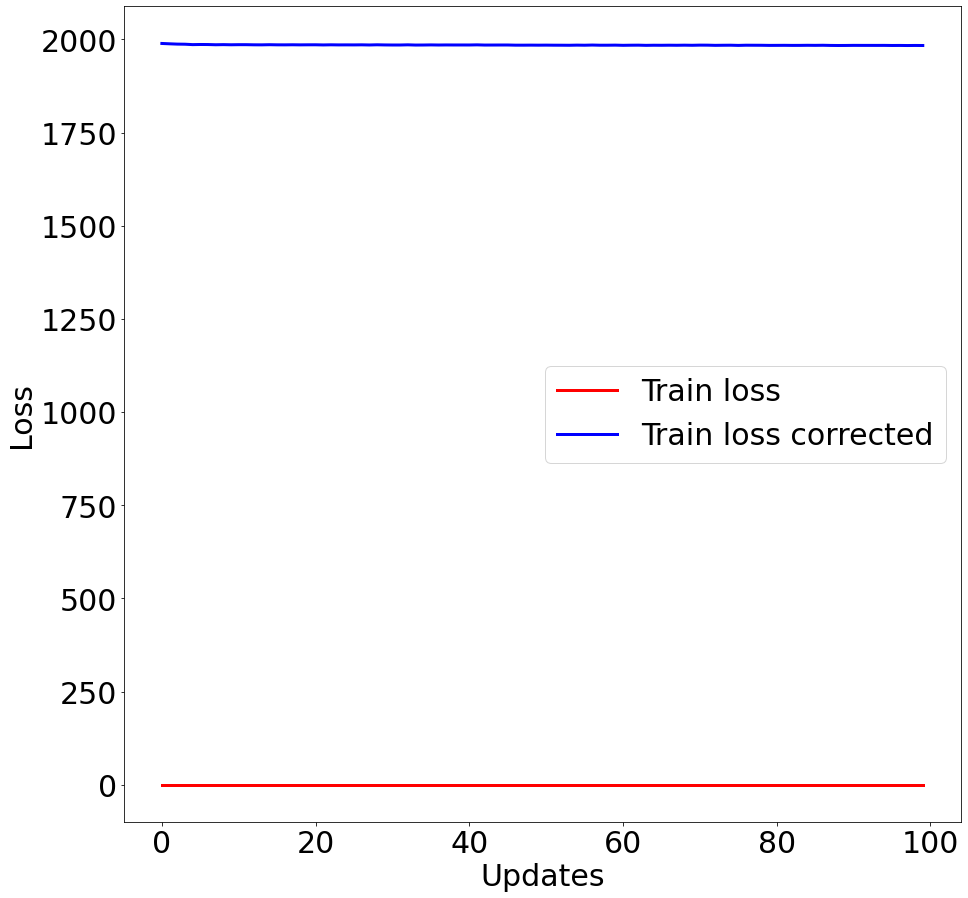

In [47]:
# setting hyperparameters and gettings epoch sizes
batch_size = 100;
num_epochs = 100
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
train_losses = []
valid_losses = []     # EDIT 22/11
loss_correct = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])                                    

        
        # compute gradients given loss
        target_batch = targets_train[slce]
        batch_loss = criterion(output, target_batch)
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    train_losses.append(cur_loss / (batch_size*num_batches_train));   # EDIT
    loss_correct.append(math.sqrt(cur_loss / batch_size)*max_age)

    net.eval()
    """
    cur_loss = 0;
    for i in range(num_batches_valid):
      optimizer.zero_grad();
      slce = get_slice(i,batch_size)
      output = net(x_valid[slce]);

      target_batch = targets_valid[slce];
      batch_loss = criterion(output, target_batch);
      cur_loss += batch_loss;
    valid_losses.append(cur_loss / (batch_size*num_batches_train));

    # No reason to evaluate based upon classification
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(x_train[slce])
        
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce].numpy())
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        
        output = net(x_valid[slce])
        preds = torch.max(output, 1)[1]
        val_targs += list(targets_valid[slce].numpy())
        val_preds += list(preds.data.numpy())
    """
    
    if epoch % 5 == 0:
        print("Epoch %2i : Train Loss: %f,\tTrain Loss Corrected: %f,\tValidation Loss: N/A" % (
                epoch+1, train_losses[-1], loss_correct[-1]))

epoch = np.arange(len(train_losses))

plt.figure(figsize=(15,15))
plt.rcParams['font.size'] = '30'
plt.plot(epoch, train_losses, 'r', epoch, loss_correct, 'b', linewidth=3.0)
plt.legend(['Train loss', 'Train loss corrected'])
plt.xlabel('Updates'), plt.ylabel('Loss')

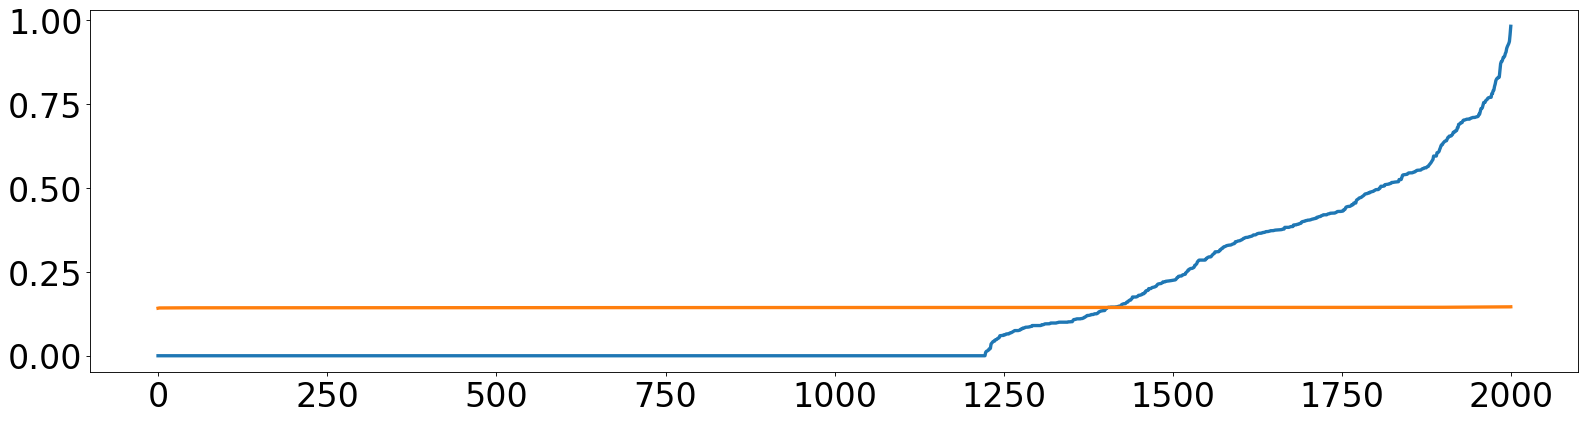

In [48]:
d = batch_size;
k = int(2000/batch_size);
lower = 0;
upper = lower+d;

y3 = np.array([]);

for i in range(k):
  #print(temp);
  y3 = np.append(y3,get_numpy(net(x_train[lower+d*i:upper+d*i])).flatten());
y1 = x_train_target[lower:lower+d*k];

# print(get_numpy(net(x_train[lower:upper])).flatten());
y2 = get_numpy(net(x_train[lower:upper]));
y4 = np.array([y3,y1]);
y4 = np.sort(y4,axis=1);

plt.figure(figsize=(24, 6), dpi=80)
plt.rcParams['font.size'] = '30'
plt.plot(range(lower,lower+d*k),y4[1],linewidth=3.0);
plt.plot(range(lower,lower+d*k),y4[0],linewidth=3.0);
plt.show();